In [204]:
%matplotlib inline

In [3]:
from catboost import Pool, CatBoostRegressor, cv

In [4]:
from sklearn.neural_network import MLPRegressor

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

In [6]:
from sklearn.preprocessing import QuantileTransformer

In [29]:
data_all = pd.read_csv('lab_dataset_filtered_ss.csv')
data_all

,Theta,Alpha,Beta,TotalAbsPow,Theta_watch-relax,Alpha_watch-relax,Beta_watch-relax,Beta/Alpha,Beta/(Alpha + Theta),ApEn,...,ShanEn,SpEn,WPEn,ch,film,Subj,labels,Theta_ratio,Alpha_ratio,Beta_ratio
0,0.924152,-0.348300,-0.622420,-0.225034,0.936071,0.591321,0.422607,-0.016480,0.023524,0.467226,...,-0.776394,0.705214,0.108535,1,1,1,10,0.526244,0.203860,0.269896
1,-0.348267,-0.600749,-0.730337,-0.764700,0.231549,0.568066,0.433714,-0.004141,0.051833,0.913646,...,-0.777058,1.131179,0.098708,2,1,1,10,0.421152,0.211133,0.367715
2,-0.759009,-0.704054,-0.700449,-0.906011,0.323318,0.442627,0.446898,-0.395897,-1.399843,0.388313,...,-0.777501,0.281090,0.101992,3,1,1,10,0.348217,0.193641,0.458142
3,0.151501,-0.309137,-0.530468,-0.374458,0.518853,0.673120,0.480428,-0.016461,0.028944,0.478278,...,-0.778830,0.200154,0.123583,4,1,1,10,0.414250,0.247133,0.338618
4,0.816282,0.024789,-0.545983,-0.035661,0.494381,0.808073,0.390293,-0.042396,0.022442,0.189155,...,-0.776615,0.791241,0.087113,6,1,1,10,0.455908,0.279164,0.264928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,0.071492,-0.508365,-0.362921,-0.384172,0.548654,0.163089,0.369495,-0.057522,0.013862,-1.240162,...,0.580462,-1.382807,0.057060,14,8,12,2,0.410116,0.176919,0.412965
1572,-0.388167,-0.583862,-0.262131,-0.501318,0.378833,0.274467,0.454414,-0.083926,0.000261,-1.018442,...,0.581177,-1.298166,0.008961,15,8,12,2,0.326135,0.169916,0.503949
1573,-0.963380,-0.732001,-0.182975,-0.678454,-0.062870,0.369721,0.587380,-0.191511,0.001740,-1.158967,...,0.579925,-1.403021,0.098022,16,8,12,2,0.216626,0.135352,0.648022
1574,-0.767503,-0.705782,0.041223,-0.502484,0.337532,0.364886,0.687097,-0.235863,-0.087258,-0.781878,...,0.580998,-1.321126,0.094782,17,8,12,2,0.228281,0.121847,0.649872


In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
X = pd.concat([data_all.drop(['film', 'labels', 'Subj', 'ch'], axis=1), pd.get_dummies(data_all['ch'], prefix='ch')], axis=1)
y = data_all['labels']

In [9]:
from sklearn.model_selection import GroupKFold

In [10]:
group_kfold = GroupKFold(n_splits=12)
gkf = group_kfold.get_n_splits(X, y, data_all['Subj'])

In [11]:
params = {
    'hidden_layer_sizes': [(100, ), (150,100,50)],
    'max_iter': [100, 500],
    'solver' : ['sgd'],
    'activation' : ['tanh', 'relu'],
    'learning_rate' : ['constant','adaptive'],
}

In [12]:
model = MLPRegressor()

In [13]:
grid = GridSearchCV(model, params, cv=gkf, verbose=4)

In [ ]:
grid.fit(X, y)

In [20]:
params = grid.best_params_

In [18]:
grid.best_params_

{'activation': 'tanh',
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'max_iter': 100,
 'solver': 'sgd'}

In [19]:
grid.best_score_

-0.3530029939223809

In [30]:
X_test = data_all.loc[(data_all['Subj']  == 11)].reset_index(drop=True)
X_train = data_all.loc[(data_all['Subj'] != 11)].reset_index(drop=True)
X_train = X_train.sample(frac=1)
X_test = X_test.sample(frac=1)

y_train = X_train['labels']
y_test_inv = np.array(X_test['labels'])
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train.drop(['film','ch', 'labels', 'Subj'], axis=1)
X_test = X_test.drop(['film','ch', 'labels', 'Subj'], axis=1)


qt_train = QuantileTransformer(output_distribution='normal',
                           copy=True)
y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
qt_test = QuantileTransformer(output_distribution='normal',
                             copy=True)
y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))

n_quantiles (1000) is greater than the total number of samples (106). n_quantiles is set to n_samples.


In [31]:
model = MLPRegressor(activation='tanh', max_iter=100, solver='sgd')
model.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.


MLPRegressor(activation='tanh', max_iter=100, solver='sgd')

In [32]:
y_pred = model.predict(X_test)

In [33]:
preds = qt_test.inverse_transform(y_pred.reshape(-1, 1))

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

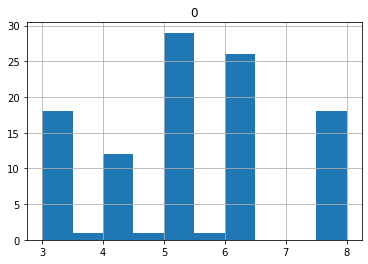

In [34]:
pd.DataFrame(preds).hist()

In [13]:
pd.DataFrame(preds).describe()

,0
count,106.000000
mean,5.356941
std,1.683205
min,3.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,8.000000


In [35]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
n_subjects = 32
n_films = 40
pred = [[0 for j in range(n_films)] for i in range(n_subjects)]
num_chans = [[0 for j in range(n_films)] for i in range(n_subjects)]
labels = [[0 for j in range(n_films)] for i in range(n_subjects)]
lbl = [[0 for j in range(n_films)] for i in range(n_subjects)]
channels = [[] for i in range(n_subjects)]
for i in range(len(preds)):
    pred[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += np.array(preds)[i]
    num_chans[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += 1
    labels[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += np.array(y_test_inv)[i]
    channels[np.array(test_subj)[i] - 1].append(chans[test_ch[i] - 1])
labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
labels = np.nan_to_num(labels)
pred = np.nan_to_num(pred)
predicted = []
lbl = []
for i in range(len(labels)):
    if sum(labels[i]) != 0:
        for j in range(n_films):
            if labels[i][j] != 0:
                lbl.append(labels[i][j])  
                predicted.append(pred[i][j])

invalid value encountered in true_divide
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
invalid value encountered in true_divide


In [36]:
for [l, p] in zip(lbl, predicted):
    print('label : {:0.2f} predicted: {:0.2f} '.format(l, p))

label : 8.00 predicted: 6.69 
label : 3.00 predicted: 4.94 
label : 5.00 predicted: 3.37 
label : 8.00 predicted: 5.68 
label : 6.00 predicted: 5.64 
label : 4.00 predicted: 5.61 


In [37]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

In [38]:
print('r2:', r2_score(lbl, predicted))
print('MAPE:', mean_absolute_percentage_error(lbl, predicted))
print('MAE : ', mean_absolute_error(lbl, predicted))

r2: 0.23651526658010524
MAPE: 0.31527880109353223
MAE :  1.530464914316937


## Таблица со значениями метрик

In [39]:
data_all

,Theta,Alpha,Beta,TotalAbsPow,Theta_watch-relax,Alpha_watch-relax,Beta_watch-relax,Beta/Alpha,Beta/(Alpha + Theta),ApEn,...,ShanEn,SpEn,WPEn,ch,film,Subj,labels,Theta_ratio,Alpha_ratio,Beta_ratio
0,0.924152,-0.348300,-0.622420,-0.225034,0.936071,0.591321,0.422607,-0.016480,0.023524,0.467226,...,-0.776394,0.705214,0.108535,1,1,1,10,0.526244,0.203860,0.269896
1,-0.348267,-0.600749,-0.730337,-0.764700,0.231549,0.568066,0.433714,-0.004141,0.051833,0.913646,...,-0.777058,1.131179,0.098708,2,1,1,10,0.421152,0.211133,0.367715
2,-0.759009,-0.704054,-0.700449,-0.906011,0.323318,0.442627,0.446898,-0.395897,-1.399843,0.388313,...,-0.777501,0.281090,0.101992,3,1,1,10,0.348217,0.193641,0.458142
3,0.151501,-0.309137,-0.530468,-0.374458,0.518853,0.673120,0.480428,-0.016461,0.028944,0.478278,...,-0.778830,0.200154,0.123583,4,1,1,10,0.414250,0.247133,0.338618
4,0.816282,0.024789,-0.545983,-0.035661,0.494381,0.808073,0.390293,-0.042396,0.022442,0.189155,...,-0.776615,0.791241,0.087113,6,1,1,10,0.455908,0.279164,0.264928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,0.071492,-0.508365,-0.362921,-0.384172,0.548654,0.163089,0.369495,-0.057522,0.013862,-1.240162,...,0.580462,-1.382807,0.057060,14,8,12,2,0.410116,0.176919,0.412965
1572,-0.388167,-0.583862,-0.262131,-0.501318,0.378833,0.274467,0.454414,-0.083926,0.000261,-1.018442,...,0.581177,-1.298166,0.008961,15,8,12,2,0.326135,0.169916,0.503949
1573,-0.963380,-0.732001,-0.182975,-0.678454,-0.062870,0.369721,0.587380,-0.191511,0.001740,-1.158967,...,0.579925,-1.403021,0.098022,16,8,12,2,0.216626,0.135352,0.648022
1574,-0.767503,-0.705782,0.041223,-0.502484,0.337532,0.364886,0.687097,-0.235863,-0.087258,-0.781878,...,0.580998,-1.321126,0.094782,17,8,12,2,0.228281,0.121847,0.649872


In [40]:
from tqdm import tqdm_notebook

In [41]:
models = ['MLPRegressor']
metrics = ['MAPE', 'MAE', 'R2']
formes = ['inverted', 'average']
columns = [
    np.array([models[i] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([metrics[j] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([formes[k] for i in range(1) for j in range(3) for k in range(2)]),
]

In [42]:
data_all = pd.concat([data_all, pd.get_dummies(data_all['ch'], prefix='ch')], axis=1)
data_all

,Theta,Alpha,Beta,TotalAbsPow,Theta_watch-relax,Alpha_watch-relax,Beta_watch-relax,Beta/Alpha,Beta/(Alpha + Theta),ApEn,...,ch_9,ch_10,ch_11,ch_12,ch_13,ch_14,ch_15,ch_16,ch_17,ch_18
0,0.924152,-0.348300,-0.622420,-0.225034,0.936071,0.591321,0.422607,-0.016480,0.023524,0.467226,...,0,0,0,0,0,0,0,0,0,0
1,-0.348267,-0.600749,-0.730337,-0.764700,0.231549,0.568066,0.433714,-0.004141,0.051833,0.913646,...,0,0,0,0,0,0,0,0,0,0
2,-0.759009,-0.704054,-0.700449,-0.906011,0.323318,0.442627,0.446898,-0.395897,-1.399843,0.388313,...,0,0,0,0,0,0,0,0,0,0
3,0.151501,-0.309137,-0.530468,-0.374458,0.518853,0.673120,0.480428,-0.016461,0.028944,0.478278,...,0,0,0,0,0,0,0,0,0,0
4,0.816282,0.024789,-0.545983,-0.035661,0.494381,0.808073,0.390293,-0.042396,0.022442,0.189155,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,0.071492,-0.508365,-0.362921,-0.384172,0.548654,0.163089,0.369495,-0.057522,0.013862,-1.240162,...,0,0,0,0,0,1,0,0,0,0
1572,-0.388167,-0.583862,-0.262131,-0.501318,0.378833,0.274467,0.454414,-0.083926,0.000261,-1.018442,...,0,0,0,0,0,0,1,0,0,0
1573,-0.963380,-0.732001,-0.182975,-0.678454,-0.062870,0.369721,0.587380,-0.191511,0.001740,-1.158967,...,0,0,0,0,0,0,0,1,0,0
1574,-0.767503,-0.705782,0.041223,-0.502484,0.337532,0.364886,0.687097,-0.235863,-0.087258,-0.781878,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
result = pd.DataFrame()
grid_res = []
n_films = 8
n_subjects = 12
for film in tqdm_notebook(range(1, n_films + 1)):
    df = pd.DataFrame(np.random.randn(1, 1 * 3 * 2), columns=columns)
    X_test = data_all.loc[(data_all['film'] == film)].reset_index(drop=True)
    X_train = data_all.loc[(data_all['film'] != film)].reset_index(drop=True)
    X_train = X_train.sample(frac=1)
    X_test = X_test.sample(frac=1)

    y_train = X_train['labels']
    y_test_inv = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    
    X_train = X_train.drop(['film','ch', 'Subj', 'labels'], axis=1)
    X_test = X_test.drop(['film','ch', 'Subj', 'labels'], axis=1)
    
    qt_train = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
    qt_test = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))
    
    model = MLPRegressor(activation='tanh', max_iter=100, solver='sgd')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds = qt_test.inverse_transform(np.array(y_pred).reshape(-1, 1))
    df[('MLPRegressor', 'R2', 'inverted')] = r2_score(preds, y_test_inv)
    df[('MLPRegressor', 'MAPE', 'inverted')] = mean_absolute_percentage_error(preds, y_test_inv)
    df[('MLPRegressor', 'MAE', 'inverted')] = mean_absolute_error(preds, y_test_inv)
    
    pred = [[0 for j in range(n_films)] for i in range(n_subjects)]
    num_chans = [[0 for j in range(n_films)] for i in range(n_subjects)]
    labels = [[0 for j in range(n_films)] for i in range(n_subjects)]
    lbl = [[0 for j in range(n_films)] for i in range(n_subjects)]
    channels = [[] for i in range(n_subjects)]
    for i in range(len(preds)):
        pred[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += preds[i]
        num_chans[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += 1
        labels[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += y_test_inv[i]
        channels[np.array(test_subj)[i] - 1].append(chans[test_ch[i] - 1])
    labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
    pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
    labels = np.nan_to_num(labels)
    pred = np.nan_to_num(pred)
    predicted = []
    lbl = []
    for i in range(len(labels)):
        if sum(labels[i]) != 0:
            for j in range(n_films):
                if labels[i][j] != 0:
                    lbl.append(labels[i][j])  
                    predicted.append(pred[i][j])

    df[('MLPRegressor', 'R2', 'average')] = r2_score(lbl, predicted)
    df[('MLPRegressor', 'MAPE', 'average')] = mean_absolute_percentage_error(lbl, predicted)
    df[('MLPRegressor', 'MAE', 'average')] = mean_absolute_error(lbl, predicted)
    result = pd.concat([result, df], axis=0)

In [44]:
result

MLPRegressor                                                  
          MAPE                 MAE                  R2          
      inverted   average  inverted   average  inverted   average
0     0.226646  0.365114  1.774943  1.701304 -2.131516  0.240823
0     0.449316  0.536740  2.419507  2.351941 -2.343726 -0.234221
0     0.459378  0.439398  1.639174  1.526078 -1.389831 -0.174438
0     0.713003  0.684184  2.773633  2.753326 -1.495197 -0.239258
0     0.328362  1.168603  3.031375  2.924211 -7.691469 -1.266576
0     0.258429  0.325475  1.431710  1.285876 -0.266752  0.537353
0     0.215077  0.286050  1.275626  1.180297 -1.221677  0.235959
0     0.571638  0.526127  2.304270  2.042666 -0.764712  0.096193

In [45]:
result.to_excel('metrics_MLP_lab3.xlsx')

In [46]:
result.describe()

MLPRegressor                                                  
              MAPE                 MAE                  R2          
          inverted   average  inverted   average  inverted   average
count     8.000000  8.000000  8.000000  8.000000  8.000000  8.000000
mean      0.402731  0.541462  2.081280  1.970712 -2.163110 -0.100520
std       0.178386  0.284689  0.644368  0.658591  2.332333  0.544792
min       0.215077  0.286050  1.275626  1.180297 -7.691469 -1.266576
25%       0.250483  0.355205  1.587308  1.466028 -2.184569 -0.235480
50%       0.388839  0.482763  2.039607  1.871985 -1.442514 -0.039122
75%       0.487443  0.573601  2.508039  2.452287 -1.107436  0.237175
max       0.713003  1.168603  3.031375  2.924211 -0.266752  0.537353

In [47]:
result.describe().to_excel('metrics_MLP_lab_described3.xlsx')

In [49]:
import warnings
import logging
warnings.filterwarnings('ignore')

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logging.getLogger("shap").setLevel(logging.WARNING)

## Таблицы со значениями shap для всех фильмов (1 на тест, остальные на обучение)

In [52]:
data_all = pd.read_csv('lab_dataset_filtered_pt.csv')
data_all

,Theta,Alpha,Beta,Theta_ratio,Alpha_ratio,Beta_ratio,TotalAbsPow,Theta_watch-relax,Alpha_watch-relax,Beta_watch-relax,...,SFD,SVDEn,SampEn,ShanEn,SpEn,WPEn,ch,film,Subj,labels
0,1.093719,-0.090028,-0.787628,2.239133,-0.340804,-1.611743,0.064611,0.934433,0.631953,0.526372,...,0.549529,0.217745,0.473748,-0.914338,0.690274,0.397238,1,1,1,10
1,-0.124440,-0.838446,-1.156987,1.124749,-0.253206,-0.553372,-0.926201,0.239272,0.587180,0.568068,...,0.828022,0.702576,1.026650,-0.914876,1.148056,0.327123,2,1,1,10
2,-0.837541,-1.306514,-1.046465,0.367346,-0.468221,0.283139,-1.317627,0.330685,0.369017,0.618984,...,0.906029,0.112702,0.276171,-0.915235,0.248037,0.350497,3,1,1,10
3,0.469474,-0.004394,-0.527265,1.052499,0.145622,-0.849910,-0.155425,0.524311,0.797950,0.754958,...,0.549204,0.241418,0.458677,-0.916311,0.165182,0.505668,4,1,1,10
4,1.020630,0.545315,-0.568309,1.490334,0.457166,-1.670463,0.304862,0.500144,1.096215,0.411864,...,0.138179,0.026393,0.170100,-0.914517,0.781626,0.245095,6,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,0.387746,-0.515468,-0.143158,1.009291,-0.688288,-0.119618,-0.170846,0.553720,0.002592,0.344126,...,-1.143108,-1.257425,-1.181317,0.513857,-1.356292,0.035951,14,8,12,2
1572,-0.182354,-0.773804,0.046644,0.140698,-0.784956,0.663638,-0.369385,0.385795,0.136567,0.648676,...,-0.940008,-0.994855,-1.055838,0.514814,-1.279704,-0.288597,15,8,12,2
1573,-1.331758,-1.460347,0.179153,-0.964332,-1.304915,1.705564,-0.723384,-0.055946,0.262184,1.241987,...,-1.070552,-0.949559,-1.187084,0.513140,-1.374503,0.322250,16,8,12,2
1574,-0.855706,-1.315628,0.494101,-0.848255,-1.529318,1.717607,-0.371487,0.344807,0.255482,1.756505,...,-0.835018,-0.827281,-0.816938,0.514575,-1.300532,0.299264,17,8,12,2


In [54]:
import os

In [55]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
result = pd.DataFrame()
grid_res = []
n_films = 8
for film in tqdm_notebook(range(1, n_films + 1)):
    if os.path.isfile('F{}_mlp_lab.png'.format(film)):
        continue
    X_test = data_all.loc[(data_all['film'] == film)].reset_index(drop=True)
    X_train = data_all.loc[(data_all['film'] != film)].reset_index(drop=True)
    X_train = X_train.sample(frac=1)
    X_test = X_test.sample(frac=1)

    y_train = X_train['labels']
    y_test = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    
    X_train = X_train.drop(['film', 'ch', 'Subj', 'labels', 'ch'], axis=1)
    X_test = X_test.drop(['film', 'ch', 'Subj', 'labels', 'ch'], axis=1)
    
    
    model = MLPRegressor(activation='tanh', max_iter=100, solver='sgd')
    model.fit(X_train, y_train)
    X_train_summary = shap.kmeans(X_train, 10)
    explainer = shap.KernelExplainer(model.predict, X_train_summary)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, max_display=23, show=False)
    plt.savefig('F{}_mlp_lab.png'.format(film),  bbox_inches='tight')
    plt.clf()

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.


  0%|          | 0/205 [00:00<?, ?it/s]

<Figure size 576x770.4 with 0 Axes>